## Overview

This tutorial is based on [Performing Spatial Queries (QGIS3)](https://www.qgistutorials.com/en/docs/3/performing_spatial_queries.html).

We will be working with 2 data layers for the city of Melbourne, Australia. Given the data layers for the pubs and bars in the city and locations of all metro stations, we want to find out all bars and pubs within 500 meters of a metro station.

Input Layers:
* `metro_stations_accessbility.zip`: A shapefile of metro stations in Melbourne
* `Bars_and_pubs__with_patron_capacity.csv`: CSV file with location of bars and pubs in Melbournse

Output:
* `spatial_query.gpkg`: A GeoPackage containing all bars and pubs within 500 meters of a metro station

Data Credit: 2019 The City of Melbourne Open Data Portal. Data provided by Metro Trains Melbourne and Census of Land Use and Employment (CLUE)

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
try:
    import geopandas
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        !apt install libspatialindex-dev -qq
        !pip install fiona shapely pyproj rtree --quiet
        !pip install geopandas --quiet
    else:
        print('geopandas not found, please install via conda in your environment')

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'Bars_and_pubs__with_patron_capacity.csv')
download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'metro_stations_accessbility.zip')

## Procedure

Read the `Bars_and_pubs__with_patron_capacity.csv` file and convert it to a GeoDataFrame.

In [ ]:
csv_file = 'Bars_and_pubs__with_patron_capacity.csv'
csv_path = os.path.join(data_folder, csv_file)
barspubs_df = pd.read_csv(csv_path) 
barspubs_df

Census year  Block ID  Property ID  Base property ID  \
0            2002       247       106238            106238   
1            2002       252       106244            106244   
2            2006        16       104018            104018   
3            2002       214       106186            106186   
4            2008        76       589841            105749   
...           ...       ...          ...               ...   
3333         2017        85       105746            105746   
3334         2017        74       104662            104662   
3335         2017       268       108154            108153   
3336         2017       104       104085            104085   
3337         2017        33       100730            100730   

                  Street address  CLUE small area            Trading name  \
0           192-202 Lygon Street          Carlton        Players On Lygon   
1           160-162 Lygon Street          Carlton            Bar Centrale   
2        172-192 Flinders Street  Melbourne (CBD)          Purple Emerald   
3           414-422 Lygon Street          Carlton     Percys Bar & Bistro   
4     221 Little Lonsdale Street  Melbourne (CBD)                JWow Bar   
...                          ...              ...                     ...   
3333     183-265 La Trobe Street  Melbourne (CBD)  Equinox Bar Restaurant   
3334     106-112 Hardware Street  Melbourne (CBD)         Nieuw Amsterdam   
3335         49 Rathdowne Street          Carlton       Epocha Restaurant   
3336     167-175 Franklin Street  Melbourne (CBD)               Disco Bar   
3337            12-16 Bank Place  Melbourne (CBD)   Melbourne Savage Club   

      Number of patrons  x coordinate  y coordinate  \
0                   200    144.967052    -37.802459   
1                   500    144.966770    -37.803442   
2                   110    144.968543    -37.816639   
3                   120    144.967813    -37.796946   
4                   100    144.965703    -37.810658   
...                 ...           ...           ...   
3333                 80    144.963019    -37.810733   
3334                200    144.960680    -37.812136   
3335                124    144.968594    -37.805787   
3336                200    144.959154    -37.808960   
3337                 90    144.960577    -37.816545   

                         Location  
0     (-37.80245924, 144.9670522)  
1     (-37.80344164, 144.9667699)  
2     (-37.81663851, 144.9685429)  
3     (-37.79694555, 144.9678126)  
4       (-37.810658, 144.9657034)  
...                           ...  
3333  (-37.81073331, 144.9630189)  
3334  (-37.81213605, 144.9606805)  
3335  (-37.80578725, 144.9685944)  
3336  (-37.80895967, 144.9591538)  
3337  (-37.81654467, 144.9605765)  

[3338 rows x 11 columns]

You will note that the data contains multiple features for each establishment from different years. Let's sort by *Property ID* and check.

In [ ]:
barspubs_df = barspubs_df.sort_values('Property ID')
barspubs_df

Census year  Block ID  Property ID  Base property ID  \
3129         2017       103       100160            100160   
709          2011       103       100160            100160   
2553         2015       103       100160            100160   
247          2008       103       100160            100160   
2201         2010       103       100160            100160   
...           ...       ...          ...               ...   
2579         2015      1105       628712            628712   
2832         2016        66       635138            635138   
3069         2017        66       635138            635138   
3058         2016       270       664626            104468   
3228         2017       270       664626            104468   

                Street address  CLUE small area                 Trading name  \
3129  196-200 A'Beckett Street  Melbourne (CBD)  Nomads Industry Backpackers   
709   196-200 A'Beckett Street  Melbourne (CBD)  Nomads Industry Backpackers   
2553  196-200 A'Beckett Street  Melbourne (CBD)  Nomads Industry Backpackers   
247   196-200 A'Beckett Street  Melbourne (CBD)  Nomads Industry Backpackers   
2201  196-200 A'Beckett Street  Melbourne (CBD)  Nomads Industry Backpackers   
...                        ...              ...                          ...   
2579    717-731 Collins Street        Docklands                 Bar Nicional   
2832         13 Heffernan Lane  Melbourne (CBD)               Union Electric   
3069         13 Heffernan Lane  Melbourne (CBD)               Union Electric   
3058        230 Grattan Street        Parkville                      HJC Bar   
3228        230 Grattan Street        Parkville                      HJC Bar   

      Number of patrons  x coordinate  y coordinate  \
3129                200    144.957445    -37.809985   
709                 200    144.957445    -37.809985   
2553                200    144.957445    -37.809985   
247                 200    144.957445    -37.809985   
2201                200    144.957445    -37.809985   
...                 ...           ...           ...   
2579                 75    144.950093    -37.820687   
2832                 72    144.966591    -37.811802   
3069                 72    144.966591    -37.811802   
3058                200    144.961247    -37.797398   
3228                200    144.961247    -37.797398   

                         Location  
3129  (-37.80998494, 144.9574447)  
709   (-37.80998494, 144.9574447)  
2553  (-37.80998494, 144.9574447)  
247   (-37.80998494, 144.9574447)  
2201  (-37.80998494, 144.9574447)  
...                           ...  
2579  (-37.82068699, 144.9500934)  
2832  (-37.81180178, 144.9665913)  
3069  (-37.81180178, 144.9665913)  
3058  (-37.79739836, 144.9612468)  
3228  (-37.79739836, 144.9612468)  

[3338 rows x 11 columns]

We are interested only in the location of the establishment. So we can de-duplicate the dataframe and keep only 1 record per unique *Property ID*.

In [ ]:
barspubs_df = barspubs_df.drop_duplicates(subset=['Property ID'], keep='first')
barspubs_df

Census year  Block ID  Property ID  Base property ID  \
3129         2017       103       100160            100160   
1087         2011       409       100441            100441   
410          2004       315       100514            100514   
1501         2009        33       100727            100727   
1159         2013        33       100730            100730   
...           ...       ...          ...               ...   
1601         2009      2391       616966            616966   
1182         2013      1110       620312            593737   
3028         2016      1105       628712            628712   
2832         2016        66       635138            635138   
3058         2016       270       664626            104468   

                Street address               CLUE small area  \
3129  196-200 A'Beckett Street               Melbourne (CBD)   
1087    118-126 Ireland Street  West Melbourne (Residential)   
410       204-206 Arden Street               North Melbourne   
1501            5-9 Bank Place               Melbourne (CBD)   
1159          12-16 Bank Place               Melbourne (CBD)   
...                        ...                           ...   
1601           2 Boundary Road               North Melbourne   
1182       23-37 Star Crescent                     Docklands   
3028    717-731 Collins Street                     Docklands   
2832         13 Heffernan Lane               Melbourne (CBD)   
3058        230 Grattan Street                     Parkville   

                                   Trading name  Number of patrons  \
3129                Nomads Industry Backpackers                200   
1087                              Railway Hotel                241   
410   North Melbourne Football Club Social Club                210   
1501                               Mitre Tavern                300   
1159                      Melbourne Savage Club                 90   
...                                         ...                ...   
1601          Vodka Locka & Red Leaf Restaurant                 40   
1182                         Harbour Town Hotel                498   
3028                               Bar Nicional                 75   
2832                             Union Electric                 72   
3058                                    HJC Bar                200   

      x coordinate  y coordinate                     Location  
3129    144.957445    -37.809985  (-37.80998494, 144.9574447)  
1087    144.942118    -37.806054  (-37.80605366, 144.9421177)  
410     144.941312    -37.799055  (-37.79905531, 144.9413118)  
1501    144.960311    -37.816805  (-37.81680457, 144.9603112)  
1159    144.960577    -37.816545  (-37.81654467, 144.9605765)  
...            ...           ...                          ...  
1601    144.939233    -37.795318  (-37.79531826, 144.9392333)  
1182    144.937830    -37.813150  (-37.81315031, 144.9378299)  
3028    144.950093    -37.820687  (-37.82068699, 144.9500934)  
2832    144.966591    -37.811802  (-37.81180178, 144.9665913)  
3058    144.961247    -37.797398  (-37.79739836, 144.9612468)  

[308 rows x 11 columns]

Now that we are done with data cleaning, let's turn this dataframe in to a spatial layer. The location of the establishment is defined using the *x coordinate* and *y coordinate* columns. Create a geometry column and use it to define a new GeoDataFrame.

In [ ]:
geometry=gpd.points_from_xy(barspubs_df['x coordinate'],barspubs_df['y coordinate'])
barspubs_gdf = gpd.GeoDataFrame(barspubs_df, crs='EPSG:4326', geometry=geometry)
barspubs_gdf

Census year  Block ID  Property ID  Base property ID  \
3129         2017       103       100160            100160   
1087         2011       409       100441            100441   
410          2004       315       100514            100514   
1501         2009        33       100727            100727   
1159         2013        33       100730            100730   
...           ...       ...          ...               ...   
1601         2009      2391       616966            616966   
1182         2013      1110       620312            593737   
3028         2016      1105       628712            628712   
2832         2016        66       635138            635138   
3058         2016       270       664626            104468   

                Street address               CLUE small area  \
3129  196-200 A'Beckett Street               Melbourne (CBD)   
1087    118-126 Ireland Street  West Melbourne (Residential)   
410       204-206 Arden Street               North Melbourne   
1501            5-9 Bank Place               Melbourne (CBD)   
1159          12-16 Bank Place               Melbourne (CBD)   
...                        ...                           ...   
1601           2 Boundary Road               North Melbourne   
1182       23-37 Star Crescent                     Docklands   
3028    717-731 Collins Street                     Docklands   
2832         13 Heffernan Lane               Melbourne (CBD)   
3058        230 Grattan Street                     Parkville   

                                   Trading name  Number of patrons  \
3129                Nomads Industry Backpackers                200   
1087                              Railway Hotel                241   
410   North Melbourne Football Club Social Club                210   
1501                               Mitre Tavern                300   
1159                      Melbourne Savage Club                 90   
...                                         ...                ...   
1601          Vodka Locka & Red Leaf Restaurant                 40   
1182                         Harbour Town Hotel                498   
3028                               Bar Nicional                 75   
2832                             Union Electric                 72   
3058                                    HJC Bar                200   

      x coordinate  y coordinate                     Location  \
3129    144.957445    -37.809985  (-37.80998494, 144.9574447)   
1087    144.942118    -37.806054  (-37.80605366, 144.9421177)   
410     144.941312    -37.799055  (-37.79905531, 144.9413118)   
1501    144.960311    -37.816805  (-37.81680457, 144.9603112)   
1159    144.960577    -37.816545  (-37.81654467, 144.9605765)   
...            ...           ...                          ...   
1601    144.939233    -37.795318  (-37.79531826, 144.9392333)   
1182    144.937830    -37.813150  (-37.81315031, 144.9378299)   
3028    144.950093    -37.820687  (-37.82068699, 144.9500934)   
2832    144.966591    -37.811802  (-37.81180178, 144.9665913)   
3058    144.961247    -37.797398  (-37.79739836, 144.9612468)   

                         geometry  
3129  POINT (144.95744 -37.80998)  
1087  POINT (144.94212 -37.80605)  
410   POINT (144.94131 -37.79906)  
1501  POINT (144.96031 -37.81680)  
1159  POINT (144.96058 -37.81654)  
...                           ...  
1601  POINT (144.93923 -37.79532)  
1182  POINT (144.93783 -37.81315)  
3028  POINT (144.95009 -37.82069)  
2832  POINT (144.96659 -37.81180)  
3058  POINT (144.96125 -37.79740)  

[308 rows x 12 columns]

Next, we will read the zipped shapefile of metro stations as a GeoDataFrame.

In [ ]:
zip_file = 'metro_stations_accessbility.zip'
zip_path = os.path.join('zip://', data_folder, zip_file)
metrostations_gdf = gpd.read_file(zip_path)
metrostations_gdf

station        pids he_loop lift  \
0                  Alamein          No      No   No   
1                   Albion  Dot Matrix      No   No   
2               Alphington  Dot Matrix      No   No   
3                   Altona         LCD      No   No   
4                   Anstey          No      No   No   
..                     ...         ...     ...  ...   
214       Williams Landing  Dot Matrix     Yes  Yes   
215               Aircraft          No      No   No   
216  Flemington Racecourse          No      No   No   
217            Showgrounds          No      No   No   
218              Southland         LCD     Yes  Yes   

                        geometry  
0    POINT (145.07956 -37.86884)  
1    POINT (144.82471 -37.77766)  
2    POINT (145.03125 -37.77840)  
3    POINT (144.83060 -37.86725)  
4    POINT (144.96056 -37.76190)  
..                           ...  
214  POINT (144.74719 -37.87010)  
215  POINT (144.76081 -37.86660)  
216  POINT (144.90720 -37.78759)  
217  POINT (144.91498 -37.78355)  
218  POINT (145.04867 -37.95818)  

[219 rows x 5 columns]

Visualize the layers.

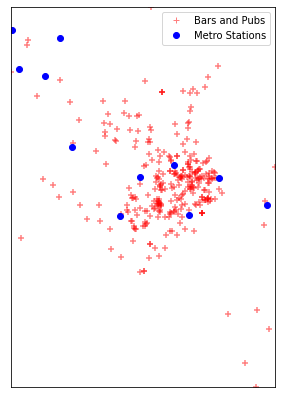

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf.plot(ax=ax, color='red', alpha=0.5, marker='+')
metrostations_gdf.plot(ax=ax, color='blue', alpha=1, marker='o')

minx, miny, maxx, maxy = barspubs_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Stations', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

For performing any analysis, we must use a Projected CRS. Let's reproject to a local CRS for Melbourne. *GDA 2020 / MGA zone 55 EPSG:7855*.

In [ ]:
metrostations_gdf_reprojected = metrostations_gdf.to_crs('EPSG:7855')
barspubs_gdf_reprojected = barspubs_gdf.to_crs('EPSG:7855')

We now buffer the metro stations to 500 meters. GeoPandas uses shapely for buffer operation. We specify [buffer parameters](https://shapely.readthedocs.io/en/latest/manual.html#constructive-methods) to match QGIS's default style.

In [ ]:
radius = 500

buffer_geometry = metrostations_gdf_reprojected.buffer(
    radius, resolution=5, cap_style=1, join_style=1, mitre_limit=2)
metrostations_gdf_reprojected['geometry'] = buffer_geometry

Visualize the buffers.

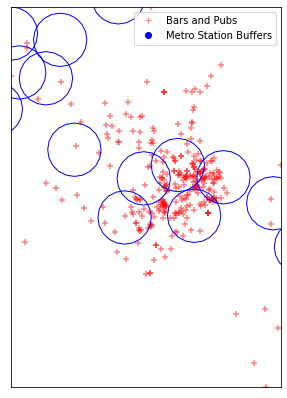

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
metrostations_gdf_reprojected.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1, marker='o')

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

As we want to do a spatial join, we need to dissolve the resulting buffers. Otherwise we will get 1 feature for every intersecting buffer

In [ ]:
metrostations_gdf_reprojected['dissolvefield'] = 1
dissolved_buffers = metrostations_gdf_reprojected.dissolve(by='dissolvefield')

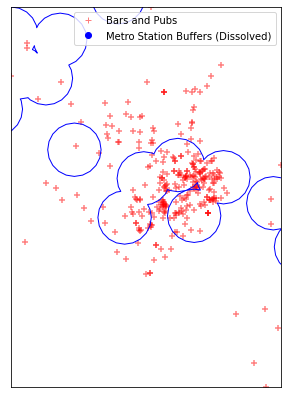

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
dissolved_buffers.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1)

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers (Dissolved)', ls='')[0]]
ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

Now do a spatial join to select all bars and pubs within the dissolved buffer region.

In [ ]:
selected = gpd.sjoin(barspubs_gdf_reprojected, dissolved_buffers, how='inner', predicate='within')
selected

Census year  Block ID  Property ID  Base property ID  \
3129         2017       103       100160            100160   
1087         2011       409       100441            100441   
3274         2017       508       100820            100820   
2929         2016        87       101023            101023   
2689         2005        14       101099            101099   
...           ...       ...          ...               ...   
2187         2009      2530       616125            616125   
1750         2012      2530       616160            616160   
1601         2009      2391       616966            616966   
3028         2016      1105       628712            628712   
2832         2016        66       635138            635138   

                Street address               CLUE small area  \
3129  196-200 A'Beckett Street               Melbourne (CBD)   
1087    118-126 Ireland Street  West Melbourne (Residential)   
3274      38-44 Barrett Street                    Kensington   
2929          25 Bennetts Lane               Melbourne (CBD)   
2689         16-26 Bond Street               Melbourne (CBD)   
...                        ...                           ...   
2187        25-27 Rankins Road                    Kensington   
1750   265-271 Racecourse Road                    Kensington   
1601           2 Boundary Road               North Melbourne   
3028    717-731 Collins Street                     Docklands   
2832         13 Heffernan Lane               Melbourne (CBD)   

                           Trading name  Number of patrons  x coordinate  \
3129        Nomads Industry Backpackers                200    144.957445   
1087                      Railway Hotel                241    144.942118   
3274                 Henry St Brewhouse                 75    144.934324   
2929            Bennetts Lane Jazz Club                300    144.967558   
2689                        Bond Lounge                500    144.963057   
...                                 ...                ...           ...   
2187   Flemington & Kensington RSL Club                 90    144.932195   
1750            The Quiet Man Irish Pub                400    144.932356   
1601  Vodka Locka & Red Leaf Restaurant                 40    144.939233   
3028                       Bar Nicional                 75    144.950093   
2832                     Union Electric                 72    144.966591   

      y coordinate                     Location  \
3129    -37.809985  (-37.80998494, 144.9574447)   
1087    -37.806054  (-37.80605366, 144.9421177)   
3274    -37.798112  (-37.79811158, 144.9343238)   
2929    -37.808892   (-37.80889245, 144.967558)   
2689    -37.818146  (-37.81814578, 144.9630575)   
...            ...                          ...   
2187    -37.789322  (-37.78932218, 144.9321953)   
1750    -37.788610  (-37.78860982, 144.9323559)   
1601    -37.795318  (-37.79531826, 144.9392333)   
3028    -37.820687  (-37.82068699, 144.9500934)   
2832    -37.811802  (-37.81180178, 144.9665913)   

                            geometry  index_right  station pids he_loop lift  
3129  POINT (320198.313 5813303.450)            1  Alamein   No      No   No  
1087  POINT (318839.353 5813710.077)            1  Alamein   No      No   No  
3274  POINT (318133.676 5814576.239)            1  Alamein   No      No   No  
2929  POINT (321086.023 5813444.098)            1  Alamein   No      No   No  
2689  POINT (320712.196 5812408.662)            1  Alamein   No      No   No  
...                              ...          ...      ...  ...     ...  ...  
2187  POINT (317924.677 5815547.421)            1  Alamein   No      No   No  
1750  POINT (317937.071 5815626.782)            1  Alamein   No      No   No  
1601  POINT (318559.131 5814895.748)            1  Alamein   No      No   No  
3028  POINT (319577.184 5812101.707)            1  Alamein   No      No   No  
2832  POINT (321007.943 5813119.409)            1  Alamein   No      No   No  

[202 rows x 17 co

For our final visualization, we show the selected establishments within the buffer zone.

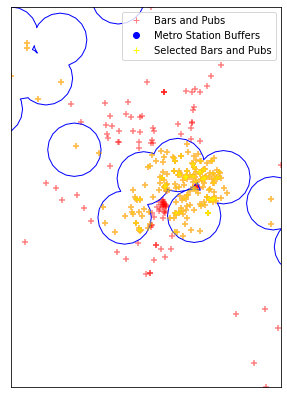

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
barspubs_gdf_reprojected.plot(ax=ax, color='red', alpha=0.5, marker='+')
dissolved_buffers.plot(ax=ax, facecolor='none', edgecolor='blue',  alpha=1)
selected.plot(ax=ax, color='yellow', alpha=0.5, marker='+')

minx, miny, maxx, maxy = barspubs_gdf_reprojected.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

legend_elements = [
    plt.plot([],[], color='red', alpha=0.5, marker='+', label='Bars and Pubs', ls='')[0],
    plt.plot([],[], color='blue', alpha=1, marker='o', label='Metro Station Buffers', ls='')[0],
    plt.plot([],[], color='yellow', alpha=1, marker='+', label='Selected Bars and Pubs', ls='')[0]
]

ax.legend(handles=legend_elements, loc='upper right')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Finally, we save all our layers into a output geopackage.

In [ ]:
output_file = 'spatial_query.gpkg'
output_path = os.path.join(output_folder, output_file)

barspubs_gdf_reprojected.to_file(driver='GPKG', filename=output_path, layer='bars_and_pubs')
metrostations_gdf_reprojected.to_file(driver='GPKG', filename=output_path, layer='metro_stations')
selected.to_file(driver='GPKG', filename=output_path, layer='selected_locations')